1847


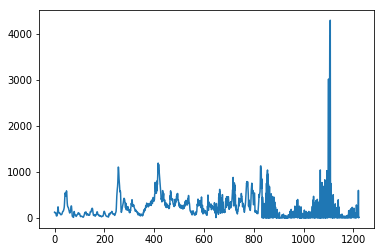

In [1]:
PROVINCE = "10"
import matplotlib.pyplot as plt
count = 0
total_cases = []
with open("total_data.csv") as f:
    for line in f.readlines():
        #print (line)
        if count ==0:
            count +=1
        else:
            line_split = line.split(",")
            
            if line_split[2] == PROVINCE and len(line_split) >=3:
                total_cases.append(float(line_split[3]))
                
print (len(total_cases))
proc_training_data_base = total_cases[(26*20):(len(total_cases) - 26*4)]
plt.plot(proc_training_data_base)
plt.show()

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in divide


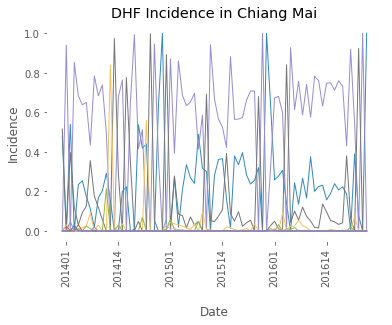

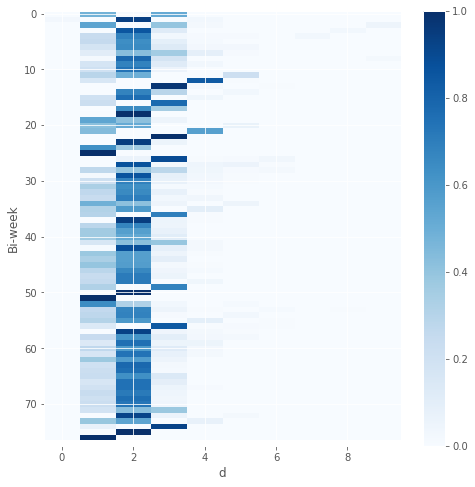

In [213]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1
plt.rcParams['axes.facecolor']='w'

n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == PROVINCE:
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
np.set_printoptions(suppress=True)    #np.set_printoptions(threshold=np.nan)


D=10
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d 

from matplotlib.pyplot import cm


def sim_data(x,y,z):
    return n_t_d[:y]

np.savetxt("foo.csv", n_t_d, delimiter=",",fmt='%f')



pos=[]
biweek_x_label = []
for year in ["2014","2015","2016"]:
    for j in np.arange(1,27,13):
        if j <= 9:
               biweek_x_label.append(year + "0"+ str(j))

        else:
               biweek_x_label.append(year +  str(j))
        if year == "2014":
               pos.append(j)
        elif year == "2015":
               pos.append(j+26)
        elif year == "2016":
               pos.append(j+26*2)

p_hat_sim = []

for i in range(len(n_t_d)):
        #print (sum(sim_n_t_d[i]/np.sum(sim_n_t_d[i])))
        p_hat_sim.append(n_t_d[i]/np.sum(n_t_d[i]))


plt.plot(p_hat_sim)
plt.xticks(pos, biweek_x_label, rotation='vertical')
plt.xlabel("\nDate")
plt.title("DHF Incidence in Chiang Mai")
plt.ylabel("Incidence")
plt.show()

plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat_sim,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()



In [208]:
from scipy.stats import norm

from scipy.stats import binom
from scipy.stats import poisson

def bayes_estimate_prob(po_data,m2,alphas,LO,N_SIM,process_training_data):
    ret_arr = []
    
    phat = alphas/sum(alphas)
  
    for row in np.arange(LO,0,-1):

                tmp = []
        
        #for s_ in range(N_SIM):
                mean_over_sim = np.mean(m2,axis=0)
                prior_prob_curr = 0
                likelihood_prob_curr = 0
                            
                trace = []
                init_cand = po_data[D-row]
                
                for MCMC in range(500):
                    mean_nb = init_cand
                    p_hat = np.random.dirichlet(alphas,1)[0]
                    tmp_n_t_inf_proposal =np.random.normal(po_data[D-row],1.*1000/sum(phat[:row]))
                    
                    
                 
                    prior_prob_prop = norm.pdf(tmp_n_t_inf_proposal,mean_over_sim[D-row],10)
                    likelihood_prob_prop = binom.pmf(po_data[D-row],tmp_n_t_inf_proposal,sum(phat[:row]))
                    accp_prob_num = prior_prob_prop*likelihood_prob_prop
                   
                    prior_prob_prop = norm.pdf(init_cand,mean_over_sim[D-row],10)
                    likelihood_prob_prop = binom.pmf(po_data[D-row],init_cand,sum(phat[:row]))

                    accp_prob_denom = prior_prob_prop*likelihood_prob_prop

                    unif_ = np.random.uniform(0,1)
                    if unif_ < 1.*accp_prob_num/accp_prob_denom:
                        init_cand = tmp_n_t_inf_proposal
                     
                    
                    trace.append(init_cand)
                tmp.append(trace[100:])
                
        #print (tmp)
        process_training_data = np.append(process_training_data,np.nanmean(tmp))
        with suppress_stdout():
            try:
                myDLM = dlm(process_training_data)
                myDLM = myDLM + seasonality(26, name='7day', w=.5)
                myDLM = myDLM + autoReg(degree=3, data=process_training_data, name='ar2', w=1.0)
                myDLM.fit()
                (process_model_forecast, predictVar) = myDLM.predictN(N=1, date=myDLM.n-1)
            except:
                process_model_forecast = po_data[D-row]
                predictVar = 1000
        for s_ in range(N_SIM):
            try:
                m2[s_][D-row+1] = process_model_forecast[0] + np.random.normal(0,np.sqrt(predictVar[0]))
            except:
                pass
        print (init_cand,po_data[D-row],sum(phat[:row]))#,process_model_forecast[0])
        ret_arr.append(tmp)
        
    return ret_arr

IndentationError: unindent does not match any outer indentation level (<ipython-input-208-9c0b454038de>, line 48)

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
(277.0, 277.0, 1.0000000000000002)
(310.3703778190336, 286.0, 0.9964641594342657)


/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


(381.0, 381.0, 0.9948569591771137)
(437.19723765144533, 425.0, 0.993571198971392)
(381.0, 381.0, 0.9929283188685312)
(28.0, 28.0, 0.9819993571198973)


/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


(587.2273059155485, 273.0, 0.923497267759563)
(556.8588537200666, 240.0, 0.6827386692381872)
(147.6351645932208, 68.0, 0.18643522982963678)
(0.0, 0.0, 0.0019286403085824494)


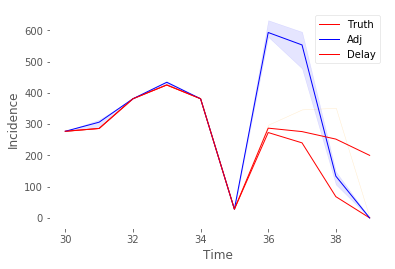

[38.910000000000004, 271.1766867276221, 93.00341522259907]
(0.1, 0.0, 0.4)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
(286.0, 286.0, 1.0)
(381.0, 381.0, 0.9967532467532467)
(425.0, 425.0, 0.9952774498229043)
(381.0, 381.0, 0.9940968122786304)
(30.098935406159022, 28.0, 0.9935064935064934)
(346.59346958446645, 275.0, 0.9778630460448642)
(362.9228880993667, 246.0, 0.9241440377804013)
(294.74431746244136, 167.0, 0.7030696576151121)
(370.8335933169588, 4.0, 0.20543093270365997)
(0.0, 0.0, 0.0017709563164108619)


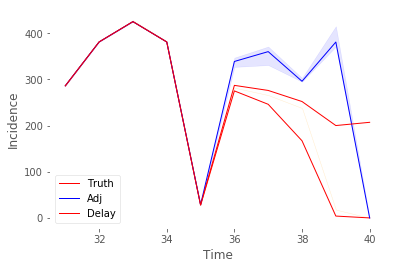

[42.451, 285.7191711788247, 56.806086584324646]
(0.2, 0.0, 0.5)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
(381.0, 381.0, 1.0)
(425.2063844600797, 425.0, 0.9970059880239521)
(381.0, 381.0, 0.9956450734893849)
(28.0, 28.0, 0.9945563418617311)
(278.0, 278.0, 0.9940119760479043)
(329.3790178487648, 258.0, 0.9795862819814917)
(237.0, 237.0, 0.8864997278170932)
(231.1034073456749, 176.0, 0.6826347305389222)
(60.07172617235396, 43.0, 0.22373434948285248)
(0.0, 0.0, 0.001633097441480675)


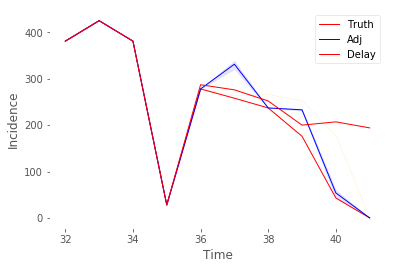

[31.431000000000004, 344.5558099311955, 45.949982811695364]
(0.2, 0.0, 0.4)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
(425.0, 425.0, 1.0)
(381.0, 381.0, 0.9972872996300863)
(28.0, 28.0, 0.9960542540073983)
(287.1531155807296, 287.0, 0.9950678175092479)
(291.2895964223606, 274.0, 0.9945745992601727)
(249.54636181728978, 246.0, 0.9815043156596794)
(200.71116490249656, 193.0, 0.89691738594328)
(500.78939058604834, 185.0, 0.6184956843403207)
(334.33773444348213, 65.0, 0.20271270036991368)
(0.0, 0.0, 0.0014796547472256474)


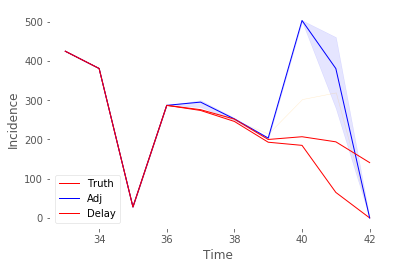

[38.407000000000004, 187.8812611196249, 64.7559356471231]
(0.3, 0.0, 0.5)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
(381.0, 381.0, 1.0)
(28.0, 28.0, 0.9975446428571428)
(317.0130102539526, 287.0, 0.9964285714285714)
(276.0, 276.0, 0.9955357142857143)
(248.32573117438955, 248.0, 0.9950892857142857)
(199.0, 199.0, 0.9832589285714285)
(258.9609800797198, 201.0, 0.9066964285714285)
(286.3811790842432, 188.0, 0.6495535714285714)
(357.95117852205317, 38.0, 0.18348214285714284)
(0.0, 0.0, 0.0013392857142857143)


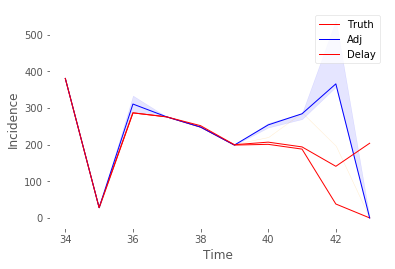

[37.477, 238.40470791766347, 59.5584125637028]
(0.2, 0.0, 0.3)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
(28.0, 28.0, 1.0)
(287.0, 287.0, 0.9977370911335116)
(283.6610406036019, 276.0, 0.9967084961941988)
(252.0, 252.0, 0.9958856202427484)
(200.0, 200.0, 0.9954741822670232)
(208.25315334441964, 206.0, 0.9845710759103065)
(450.5133802611758, 191.0, 0.9140094630734417)
(441.8339699876331, 130.0, 0.6770211890557498)
(579.2050826189128, 49.0, 0.21847356511005966)
(778.1698017108636, 0.0, 0.0012343139271754782)


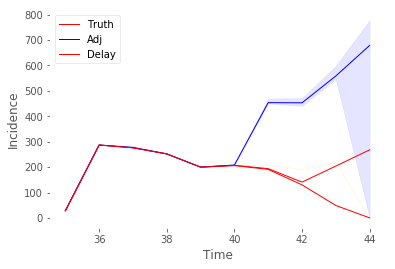

[35.293, 265.69500878802086, 133.9779490132378]
(0.1, 0.0, 0.7)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
(287.0, 287.0, 1.0)
(276.0, 276.0, 0.9977500511352015)
(252.0, 252.0, 0.9967273471057476)
(217.78022925379776, 200.0, 0.9959091838821845)
(208.94942205375705, 207.0, 0.995500102270403)
(194.45077893130826, 194.0, 0.9846594395581919)


KeyboardInterrupt: 

In [211]:
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error
from pyramid.arima import ARIMA

import os

rmse_vec_cv = []
#with suppress_stdout():
rmse_vec = []
sim_data_var = []
N_SIM = 1
sim_results_pi = []
sim_results_mse = []
for sim_num in np.arange(30,len(n_t_d)):
            sim_n_t_d = sim_data(D,sim_num,False)
            train = sim_n_t_d
            


            train = np.array(train)
            train_n_t_d = train.reshape((-1,D))
            ts = train_n_t_d.sum(axis=1)
            data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]




            delayed_data = []
            count = D
            for i in range(len(data_to_be_scaled_down)):
                tmp = data_to_be_scaled_down[i][:count].tolist()
                while len(tmp) <D:
                    tmp.append(0)
                delayed_data.append(tmp)
                count -=1 


            training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

            k = np.array(train_n_t_d).shape[1 ]
            alphas = np.ones(k)

            for i in range(len(ts)-D):
                alphas += train_n_t_d[i]

            
           
            #######
            # MODEL 1: Delay
            ########
            delay_model_samples = []
            for s_ in range(N_SIM):
                model_1_delay = []
                count = D
                p_vec_noise = np.random.dirichlet(alphas)
                for i in range(len(delayed_data)):
                    delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                    model_1_delay.append(np.round(delay_forecast,2))
                    count -= 1
                delay_model_samples.append(model_1_delay)
            
            delay_model_samples = np.array(delay_model_samples)
            

            #######
            # MODEL 2 : Forecast
            ########
            
            LO=D
            process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
            process_training_data = np.append(proc_training_data_base,process_training_data,axis=0)
            from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
            myDLM = dlm(process_training_data)
            myDLM = myDLM + seasonality(26, name='7day', w=.5)
            myDLM = myDLM + autoReg(degree=3, data=process_training_data, name='ar2', w=1.0)
            myDLM.fit()
            (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)
            
            
            
            #stepwise_model = auto_arima(process_training_data, start_p=1, start_q=1,
            #               max_p=3, max_q=3, m=26,
            #               start_P=0, seasonal=True,
            #               d=1, D=1, trace=True,
            ##               error_action='ignore',  
             #              suppress_warnings=True, 
             #              stepwise=True)
            #process_model_forecast = stepwise_model.predict(n_periods=LO)
           
            predictVar = 1*np.ones(len(process_model_forecast))
            #######
            # MODEL 2
            ########
            forecast_model_samples = []
            for s_ in range(N_SIM):
                model_2_delay = []
                count = D
                for i in np.arange(LO,0,-1):
                    tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                    model_2_delay.append(np.round(tmp,2))
                    count -= 1

                forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))
            
            forecast_model_samples = np.array(forecast_model_samples)
            
                
            model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM,process_training_data)
            
            delay_model_samples = np.transpose(np.array(delay_model_samples))
            forecast_model_samples = np.transpose(np.array(forecast_model_samples))
            
            delay_sim_res = delay_model_samples
            fcast_sim_res = forecast_model_samples
            avg_sim_res = model_average
            LO_av = np.array(avg_sim_res).reshape((LO,-1))
            LO_delay = delay_sim_res[D-LO:]
            LO_fcast = fcast_sim_res[D-LO:]
            LO_truth = ts[len(ts)-LO:]
            #print (np.mean(LO_delay,axis=1),np.mean(LO_fcast,axis=1),LO_truth\
                   #,np.mean(LO_av,axis=1))
            #sys.exit()
            sim_results_mse.append([mean_absolute_error(np.mean(LO_delay,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_fcast,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_av,axis=1),LO_truth)])
            #print (sim_results_mse[-1])
            av_cp = 0
            fcast_cp = 0
            delay_cp = 0
            LO_av_low = []
            LO_av_high = []
            LO_delay_low = []
            LO_delay_high = []
            for i in range(LO):
                LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
                LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
                LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
                LO_av_low.append(LO_av_ci[0])
                LO_av_high.append(LO_av_ci[1])
                LO_delay_low.append(LO_delay_ci[0])
                LO_delay_high.append(LO_delay_ci[1])
                
                #plt.fill_between([i],[LO_delay_ci[0]],[LO_delay_ci[1]])
               # plt.fill_between([i],LO_fcast_ci[0],LO_fcast_ci[1])
                #plt.fill_between([i],[LO_av_ci[0]],[LO_av_ci[1]])
                
                if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                    av_cp +=1

                if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                    fcast_cp +=1

                if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                    delay_cp +=1

            plt.fill_between(range(sim_num,LO+sim_num),LO_av_low,LO_av_high,alpha=.1,color='blue')
            plt.fill_between(range(sim_num,LO+sim_num),LO_delay_low,LO_delay_high,alpha=.1,color='orange')
            plt.plot(range(sim_num,sim_num+LO),np.sum(delayed_data,axis=1),color='red',ls="-")
            plt.plot(range(sim_num,sim_num+LO),np.mean(LO_av,axis=1),color='blue')
            plt.plot(range(sim_num,sim_num+LO),LO_truth,color='red')
            plt.legend(("Truth","Adj","Delay"))
            plt.ylabel("Incidence")
            plt.xlabel("Time")
            plt.show()
            #sys.exit()
            av_cp = 1.*av_cp/LO
            fcast_cp = 1.*fcast_cp/LO
            delay_cp = 1.*delay_cp/LO
            print (sim_results_mse[-1])
            print (delay_cp,fcast_cp,av_cp)
            sim_results_pi.append([delay_cp,fcast_cp,av_cp])

In [ ]:
from tabulate import tabulate

print np.mean(sim_results_pi,axis=0)
sim_results_mse = np.array(sim_results_mse)

sim_results_mse_formatted = []
for i in range(len(sim_results_mse)):
    sim_results_mse_formatted.append([i+30,sim_results_mse[i][0],sim_results_mse[i][2]])
    
print(tabulate(sim_results_mse_formatted, tablefmt="latex", floatfmt=".2f"))

print np.round(np.mean(sim_results_mse,axis=0))

wins = 0
for i in range(len(sim_results_mse)):
    if sim_results_mse[i][2] < sim_results_mse[i][0]:
        wins +=1
        
print (1.*wins/(len(sim_results_mse)))


In [37]:
from scipy.special import expit
import matplotlib.pyplot as pltq

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

cv_mse = []
season_data = []
sim_results_mse = []
sim_results_pi = []
for i in range(3):
    season_data.append(n_t_d[i:(i+26)])
    
season_data = np.array(season_data).reshape((3,-1,26))

print (season_data.shape)

for season_for_leave_out in np.arange(3):
        sim_n_t_d = season_data#[:cutoff]

        train = [sim_n_t_d[x] for x in range(3) if x not in [season_for_leave_out]]
        test = sim_n_t_d[season_for_leave_out]
        
        train = np.array(train)
        train_n_t_d = train.reshape((-1,D))
        ts = train_n_t_d.sum(axis=1)

        data_to_be_scaled_down  = test[len(test)-D:]
       
        delayed_data = []
        count = D
        for i in range(len(data_to_be_scaled_down)):
            tmp = data_to_be_scaled_down[i][:count].tolist()
            while len(tmp) <D:
                tmp.append(0)
            delayed_data.append(tmp)
            count -=1 


        training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

        k = np.array(train_n_t_d).shape[1 ]
        alphas = np.ones(k)

        for i in range(len(ts)-D):
            alphas += train_n_t_d[i]



        #######
        # MODEL 1: Delay
        ########
        delay_model_samples = []
        for s_ in range(N_SIM):
            model_1_delay = []
            count = D
            p_vec_noise = np.random.dirichlet(alphas)
            for i in range(len(delayed_data)):
                delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                model_1_delay.append(np.round(delay_forecast,2))
                count -= 1
            delay_model_samples.append(model_1_delay)

        delay_model_samples = np.array(delay_model_samples)


        #######
        # MODEL 2 : Forecast
        ########

        LO=D
        process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(process_training_data)
       # myDLM = myDLM + seasonality(26, name='7day', w=1.0)
        myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
        myDLM.fit()
        (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)

        #######
        # MODEL 2
        ########
        forecast_model_samples = []
        for s_ in range(N_SIM):
            model_2_delay = []
            count = D
            for i in np.arange(LO,0,-1):
                tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                model_2_delay.append(np.round(tmp,2))
                count -= 1

            forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))

        forecast_model_samples = np.array(forecast_model_samples)


        model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)
            
        delay_model_samples = np.transpose(np.array(delay_model_samples))
        forecast_model_samples = np.transpose(np.array(forecast_model_samples))
            
        delay_sim_res = delay_model_samples
        fcast_sim_res = forecast_model_samples
        avg_sim_res = model_average
        LO_av = np.array(avg_sim_res).reshape((LO,-1))
        LO_delay = delay_sim_res[D-LO:]
        LO_fcast = fcast_sim_res[D-LO:]
        LO_truth = ts[len(ts)-LO:]
        #print (np.mean(LO_delay,axis=1),np.mean(LO_fcast,axis=1),LO_truth\
               #,np.mean(LO_av,axis=1))
        #sys.exit()
        sim_results_mse.append([mean_absolute_error(np.mean(LO_delay,axis=1),LO_truth),\
                               mean_absolute_error(np.mean(LO_fcast,axis=1),LO_truth),\
                               mean_absolute_error(np.mean(LO_av,axis=1),LO_truth)])
        print (sim_results_mse[-1])
        av_cp = 0
        fcast_cp = 0
        delay_cp = 0
        for i in range(LO):
            LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
            LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
            LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
            print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
            if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                av_cp +=1

            if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                fcast_cp +=1

            if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                delay_cp +=1


        av_cp = 1.*av_cp/LO
        fcast_cp = 1.*fcast_cp/LO
        delay_cp = 1.*delay_cp/LO

        print (delay_cp,fcast_cp,av_cp)
        sim_results_pi.append([delay_cp,fcast_cp,av_cp])

(3, 26, 26)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[15.051926923076925, 32.414211538461544, 14.958975435630133]
(array([4., 4.]), array([-20.,  34.]), array([4., 4.]), 5.0)
(array([5., 5.]), array([-18.,  29.]), array([5., 5.]), 4.0)
(array([5., 5.]), array([-16.,  27.]), array([5., 5.]), 2.0)
(array([3., 3.]), array([-23.,  20.]), array([3., 3.]), 1.0)
(array([2., 2.]), array([-23.,  21.]), array([2., 2.]), 0.0)
(array([1., 1.]), array([-27.,  26.]), array([1., 1.]), 2.0)
(array([0., 0.]), array([-25.,  25.]), array([0., 0.]), 5.0)
(array([2., 2.]), array([-26.,  25.]), array([2., 2.]), 6.0)
(array([5., 5.]), array([-25.,  22.]), array([5., 6.]), 17.0)
(array([5., 5.]), array([-26.,  24.]), array([5., 6.]), 37.0)
(array([16., 17.]), array([-21.,  26.]), array([14., 19.]), 59.0)
(array([36., 37.]), array([-24.,  26.]), array([30., 43.]), 99.0)
(array([58., 60.]), array([-27.,  20.]), array([48., 71.]), 77.0

In [39]:

#### sim_results_pi = np.array(sim_results_pi)#### sim 
print np.mean(sim_results_pi,axis=0)

sim_results_mse = np.array(sim_results_mse)
print np.round(np.mean(sim_results_mse,axis=0)/1)

[0.1025641  0.58974359 0.37179487]
[11. 32. 11.]
